In [1]:
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import plotly.graph_objects as go
import plotly.express as px 
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_context('talk')

Import Nina's Data and join all relevant columns to my existing data.

there are concerns that I have miscalculated columns

In [2]:
orig = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/ManhattanProject/ML_dataset.csv').infer_objects()

In [3]:
econ_pop = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/ManhattanProject/3rd party Data/econ_pop.csv').infer_objects()

age_pop = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/ManhattanProject/3rd party Data/age_pop.csv').infer_objects()

In [4]:
#Import Data 

df = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/ManhattanProject/team_data_new.csv',
                 encoding='latin-1').infer_objects()

#convert columns to upper-case

df.columns = df.columns.str.upper()

#drop unnamed column

#df = df.drop('UNNAMED: 0',axis=1)

#inspect data 

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88999 entries, 0 to 88998
Columns: 212 entries, CCN to PROCESSING_DATE
dtypes: float64(165), int64(19), object(28)
memory usage: 143.9+ MB
None


In [5]:
'NET_OPERATING_MARGIN'

'NET_OPERATING_MARGIN'

# merge in 3rd party features 

In [6]:
df = (df.merge(orig[['FIPS','federal_provider_number','fiscal_year']],
          
          
         left_on=['CCN','COST_REPORT_YEAR'],
         
         
         right_on=['federal_provider_number','fiscal_year'])\
             
             
             .merge(age_pop[['FIPS','TimeFrame','perc_eld_pop','old_age_support']]\
                 
                 
                 .set_index(['FIPS','TimeFrame']),left_on=['FIPS','fiscal_year'],
                 
                    right_index=True,
)\
                        .merge(econ_pop[['FIPS','perc_poverty_avg','med_income_avg']],
                               on=['FIPS']))\
                                   .drop(['federal_provider_number','fiscal_year'],axis=1).set_index('FIPS')

dropping some duplicate rows I found. (must be a joining error that wasn't caught when provided the data)

In [7]:
df = df.drop_duplicates(subset=['CCN','COST_REPORT_YEAR','COSTREPORTNUMBER'])

In [8]:
# merge in risk standardized readmission rate 

risk = pd.read_csv('/Users/jack/Desktop/Data Analysis Practice/ManhattanProject/CRAY_PIAY_RAD.csv')[['CCN','Cost_Report_Year','Risk_Standardized_Readmission_Rate']]

df = df.merge(risk,left_on=['CCN','COST_REPORT_YEAR'],right_on=['CCN','Cost_Report_Year'])

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64603 entries, 0 to 64602
Columns: 218 entries, CCN to Risk_Standardized_Readmission_Rate
dtypes: float64(169), int64(21), object(28)
memory usage: 107.4+ MB


# FILTERING FOR FLORIDA ONLY

In [10]:
df = df[df['PROVIDER_STATE.X'] == 'NY']

# Inspecting and cleaning Nina's Dataset

In [11]:
#df = df.sort_values(by='COST_REPORT_YEAR',ascending=True)

#df.isna().sum().sort_values(ascending=False)[:50] # we realistically can't use columns with over 10k missing values as features.... 

#null_colls = df.isna().sum() >= 20_000

#df.loc[:,null_colls] # inspecting null cols 

#dropping 13 null cols and subsetting for FOR PROFIT homes only. 

#df = df.loc[:,~null_colls]\
    #.query('OWNERSHIP_TYPE == "For Profit "')

we get rid of non-profit/govt nursing homes as they aren't relevant.

In [12]:
#strip whitespace 
df[['OWNERSHIP_TYPE',
    'OWNERSHIP_TYPE_DETAIL']] = df[['OWNERSHIP_TYPE',
                                    'OWNERSHIP_TYPE_DETAIL']].apply(lambda x: x.str.strip())
    
#subset for profit only and filter out covid year of data 

df = df[(df['OWNERSHIP_TYPE'] == "For profit") & (df['COST_REPORT_YEAR'] != 2020)]

#new df shape
df.shape

(1844, 218)

In [13]:

#cats list is categorical columns i am bringing from my dataset, already preprocessed and to avoid some confusion
cats = ['PROVIDER_RESIDES_IN_HOSPITAL',
 'CONTINUING_CARE_RETIREMENT_COMMUNITY',
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT',
 'RURAL_VERSUS_URBAN_U',
 'PROVIDER_TYPE_MEDICARE AND MEDICAID']

#convert cats to lowercase to join easier 

cats = [x.lower() for x in cats]

#convert df cols to all lower

orig.columns = orig.columns.str.lower()

#define cols to join 

cols_to_join = ['federal_provider_number','fiscal_year','lat','lng','unemp','pop','facil_start_year']

In [14]:
#merge in some key features (lat, lng, pop, unemp) and drop ID cols to prepare for modeling 

df = df.merge(orig[cols_to_join + cats], # join these as defined above 
         #join cols 
         left_on=['CCN','COST_REPORT_YEAR'],
         #join cols 
         right_on=['federal_provider_number','fiscal_year'],
        how='inner' #inner join
        )\
            .drop(['CCN',
                   'federal_provider_number','fiscal_year'],axis=1) #drop these columns, they're dupes 

# Create financial ratios to reduce dimensionality

In [15]:
df = df.assign(
    # Liquidity Ratios
    Current_Ratio = df['TOTAL_CURRENT_ASSETS'] / df['TOTAL_CURRENT_LIABILITIES'],
    Quick_Ratio = (df['CASH_ON_HAND_AND_IN_BANKS'] + df['ACCOUNTS_RECEIVABLE']) / df['TOTAL_CURRENT_LIABILITIES'],
    
    #avg occupancy ratio 
    occupancy_rate = df['AVERAGE_OCCUPIED_BED_PER_DAY'].div(df['SNF_NUMBER_OF_BEDS']),

    # Debt Ratios
    Debt_to_Equity_Ratio = df['TOTAL_LIABILITIES'] / df['TOTAL_FUND_BALANCES'],
    Debt_Ratio = df['TOTAL_LIABILITIES'] / df['TOTAL_ASSETS'],
    
    #facil age 
    facil_age = df['COST_REPORT_YEAR'] - df['facil_start_year'],
    
    #total incidents 
    total_incidents = df[['NUMBER_OF_FACILITY_REPORTED_INCIDENTS',
       'NUMBER_OF_SUBSTANTIATED_COMPLAINTS',
       'NUMBER_OF_FINES',
       'NUMBER_OF_PAYMENT_DENIALS',
       'TOTAL_NUMBER_OF_PENALTIES']].sum(axis=1),
    total_equipment = df[['FIXED_EQUIPMENT','MAJOR_MOVABLE_EQUIPMENT','LAND','BUILDINGS']].sum(axis=1) #this is PPE, plant, property, equipment
)\
    .drop('facil_start_year',axis=1) # drop un-needed column


# Clean outliers (univariate)

In [16]:
def tukeys_fences(df,col):
    
    lower, upper = df[col].quantile([.25,.75]).values

    iqr = upper - lower 

    lower_lim = lower - iqr * 1.5 

    upper_lim = upper + iqr * 1.5 

    mask = (df[col] > upper_lim) | (df[col] < lower_lim)
    
    print(f'PCT of Outliers Detected in {col}: {mask.sum()/len(df):.3f}%')

    df.loc[mask,col] = np.nan
    
    return df 

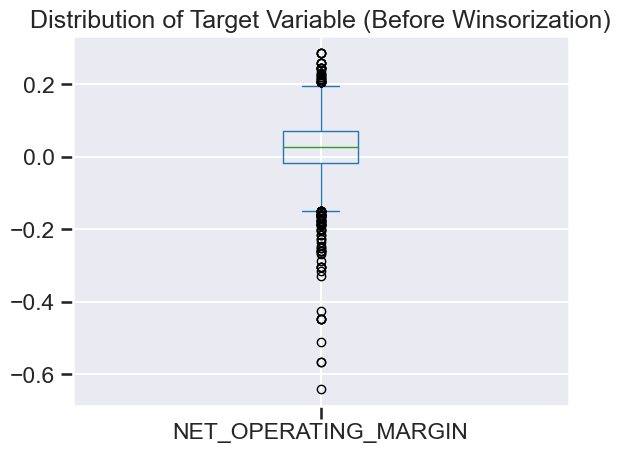

In [17]:
df.NET_OPERATING_MARGIN.plot(kind='box',
                         title='Distribution of Target Variable (Before Winsorization)') # our target contains extreme outliers, lets winsorize, then utilize tukey's fences 


lower = np.percentile(df['NET_OPERATING_MARGIN'],2.5)
          
upper = np.percentile(df['NET_OPERATING_MARGIN'],97.5)

df.loc[(df['NET_OPERATING_MARGIN'] > upper) | (df['NET_OPERATING_MARGIN'] < lower),'NET_OPERATING_MARGIN'] = np.nan  #fill outliers with NAN 

In [18]:
#list of all continuous numerical columns 

num_cols = ['COST_REPORT_YEAR', 
            'TOTAL_ASSETS',
            'TOTAL_LIABILITIES'
 'FISCAL_YEAR_DAYS', 
       'TOTAL_DAYS_TITLE_XVIII', 
       'TOTAL_DAYS_TITLE_XIX', 
       'TOTAL_DAYS_TOTAL', 
       'TOTAL_BED_DAYS_AVAILABLE',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
       'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL',
       'SNF_ADMISSIONS_TITLE_XVIII',
       'SNF_ADMISSIONS_TITLE_XIX', 
       'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL',
       'SNF_DAYS_TITLE_XVIII',
       'SNF_DAYS_TITLE_XIX',
       'SNF_DAYS_OTHER', 
       'SNF_DAYS_TOTAL', 
       'SNF_NUMBER_OF_BEDS',
       'SNF_BED_DAYS_AVAILABLE',
       'SNF_DISCHARGES_TITLE_XVIII',
       'SNF_DISCHARGES_TITLE_XIX',
       'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL',
       'TOTAL_ASSETS',
       'ACCOUNTS_PAYABLE',
       'TOTAL_CURRENT_LIABILITIES', 'TOTAL_LIABILITIES',
       'GENERAL_FUND_BALANCE', 'TOTAL_FUND_BALANCES',
       'TOTAL_LIABILITIES_AND_FUND_BALANCES',
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
       'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS',
       'Risk_Standardized_Readmission_Rate',
       'lat', 'lng', 'unemp', 'pop',
      'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #financial ratios 
       'NET_OPERATING_MARGIN', #this is our target variable 
       'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
       'occupancy_rate',
       'total_equipment',
       'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX']

# make lists of all continous columns in the dataset and all categorical columns in the dataset

I have already selected these columns from a larger dataset using various feature selection techniques

In [19]:

#all continuous column in dataset
continuous_cols = [#'FISCAL_YEAR_DAYS',
#'TYPE_OF_CONTROL', # this is categorical/nominal
      # 'TOTAL_DAYS_TITLE_XVIII', 
      # 'TOTAL_DAYS_TITLE_XIX',
      # 'TOTAL_DAYS_OTHER',
       'TOTAL_DAYS_TOTAL', 
       #'NUMBER_OF_BEDS',
       'TOTAL_BED_DAYS_AVAILABLE',
      # 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
       #'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 
       #'SNF_ADMISSIONS_TITLE_XVIII', 
       'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL', 
       #'SNF_DAYS_TITLE_XVIII',
       #'SNF_DAYS_TITLE_XIX',
       #'SNF_DAYS_OTHER', 
       'SNF_DAYS_TOTAL', 
       'SNF_NUMBER_OF_BEDS',
       'SNF_BED_DAYS_AVAILABLE',
      # 'SNF_DISCHARGES_TITLE_XVIII',
      # 'SNF_DISCHARGES_TITLE_XIX', 
      # 'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL', 
       #occupancy 
       'occupancy_rate',
       'AVERAGE_OCCUPIED_BED_PER_DAY',
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
        #penalties and fines 
      'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS', 
       'Risk_Standardized_Readmission_Rate',
       #economic/location
       'lat', 'lng',
       'unemp', 
       'pop',
        'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
       #staffing 
      # 'ADJUSTED_NURSE_AIDE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
      # 'ADJUSTED_LPN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
      # 'ADJUSTED_RN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #target 
       'NET_OPERATING_MARGIN',
       'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
       'total_equipment',
       'TOTAL_ASSETS',
      # 'TOTAL_LIABILITIES',
       'TOTAL_FUND_BALANCES',
       'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX']

#all categorical columns in dataset 
categoricals = [
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT',
 'RURAL_VERSUS_URBAN_U',
 'OWNERSHIP_TYPE_DETAIL']

In [20]:
#clean outliers using tukey's fences, this includes out target variable 



#impute outliers using tukey's fences

for col in df[continuous_cols]:
    
    # tukey's fences 
    
    pre_covid = tukeys_fences(df, col)

PCT of Outliers Detected in TOTAL_DAYS_TOTAL: 0.033%
PCT of Outliers Detected in TOTAL_BED_DAYS_AVAILABLE: 0.036%
PCT of Outliers Detected in SNF_AVERAGE_LENGTH_OF_STAY_TOTAL: 0.062%
PCT of Outliers Detected in SNF_ADMISSIONS_OTHER: 0.047%
PCT of Outliers Detected in SNF_ADMISSIONS_TOTAL: 0.053%
PCT of Outliers Detected in SNF_DAYS_TOTAL: 0.036%
PCT of Outliers Detected in SNF_NUMBER_OF_BEDS: 0.034%
PCT of Outliers Detected in SNF_BED_DAYS_AVAILABLE: 0.036%
PCT of Outliers Detected in SNF_DISCHARGES_TOTAL: 0.051%
PCT of Outliers Detected in occupancy_rate: 0.085%
PCT of Outliers Detected in AVERAGE_OCCUPIED_BED_PER_DAY: 0.034%
PCT of Outliers Detected in TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE: 0.105%
PCT of Outliers Detected in total_incidents: 0.124%
PCT of Outliers Detected in TOTAL_AMOUNT_OF_FINES_IN_DOLLARS: 0.117%
PCT of Outliers Detected in Risk_Standardized_Readmission_Rate: 0.015%
PCT of Outliers Detected in lat: 0.007%
PCT of Outliers Detected in lng: 0.110%
PCT of Outliers Detect

In [21]:
pre_covid.isna().sum().sort_values(ascending=False) # all outliers were flagged as nan here, we will impute them using knn imputer 

NF_DISCHARGES_TITLE_OTHER                                 2023
NF_ADMISSIONS_OTHER                                       2023
NF_ADMISSIONS_TITLE_V                                     2023
AVERAGE_NUMBER_OF_RESIDENTS_PER_DAY_FOOTNOTE              2023
NUMBER_OF_CITATIONS_FROM_INFECTION_CONTROL_INSPECTIONS    2023
                                                          ... 
AUTOMATIC_SPRINKLER_SYSTEMS_IN_ALL_REQUIRED_AREAS            0
PERCENT_SNF_DAYS                                             0
SNF_DAYS_TITLE_XVIII                                         0
COSTREPORTNUMBER                                             0
COST_REPORT_YEAR                                             0
Length: 236, dtype: int64

# Visualizing Distribution of Features

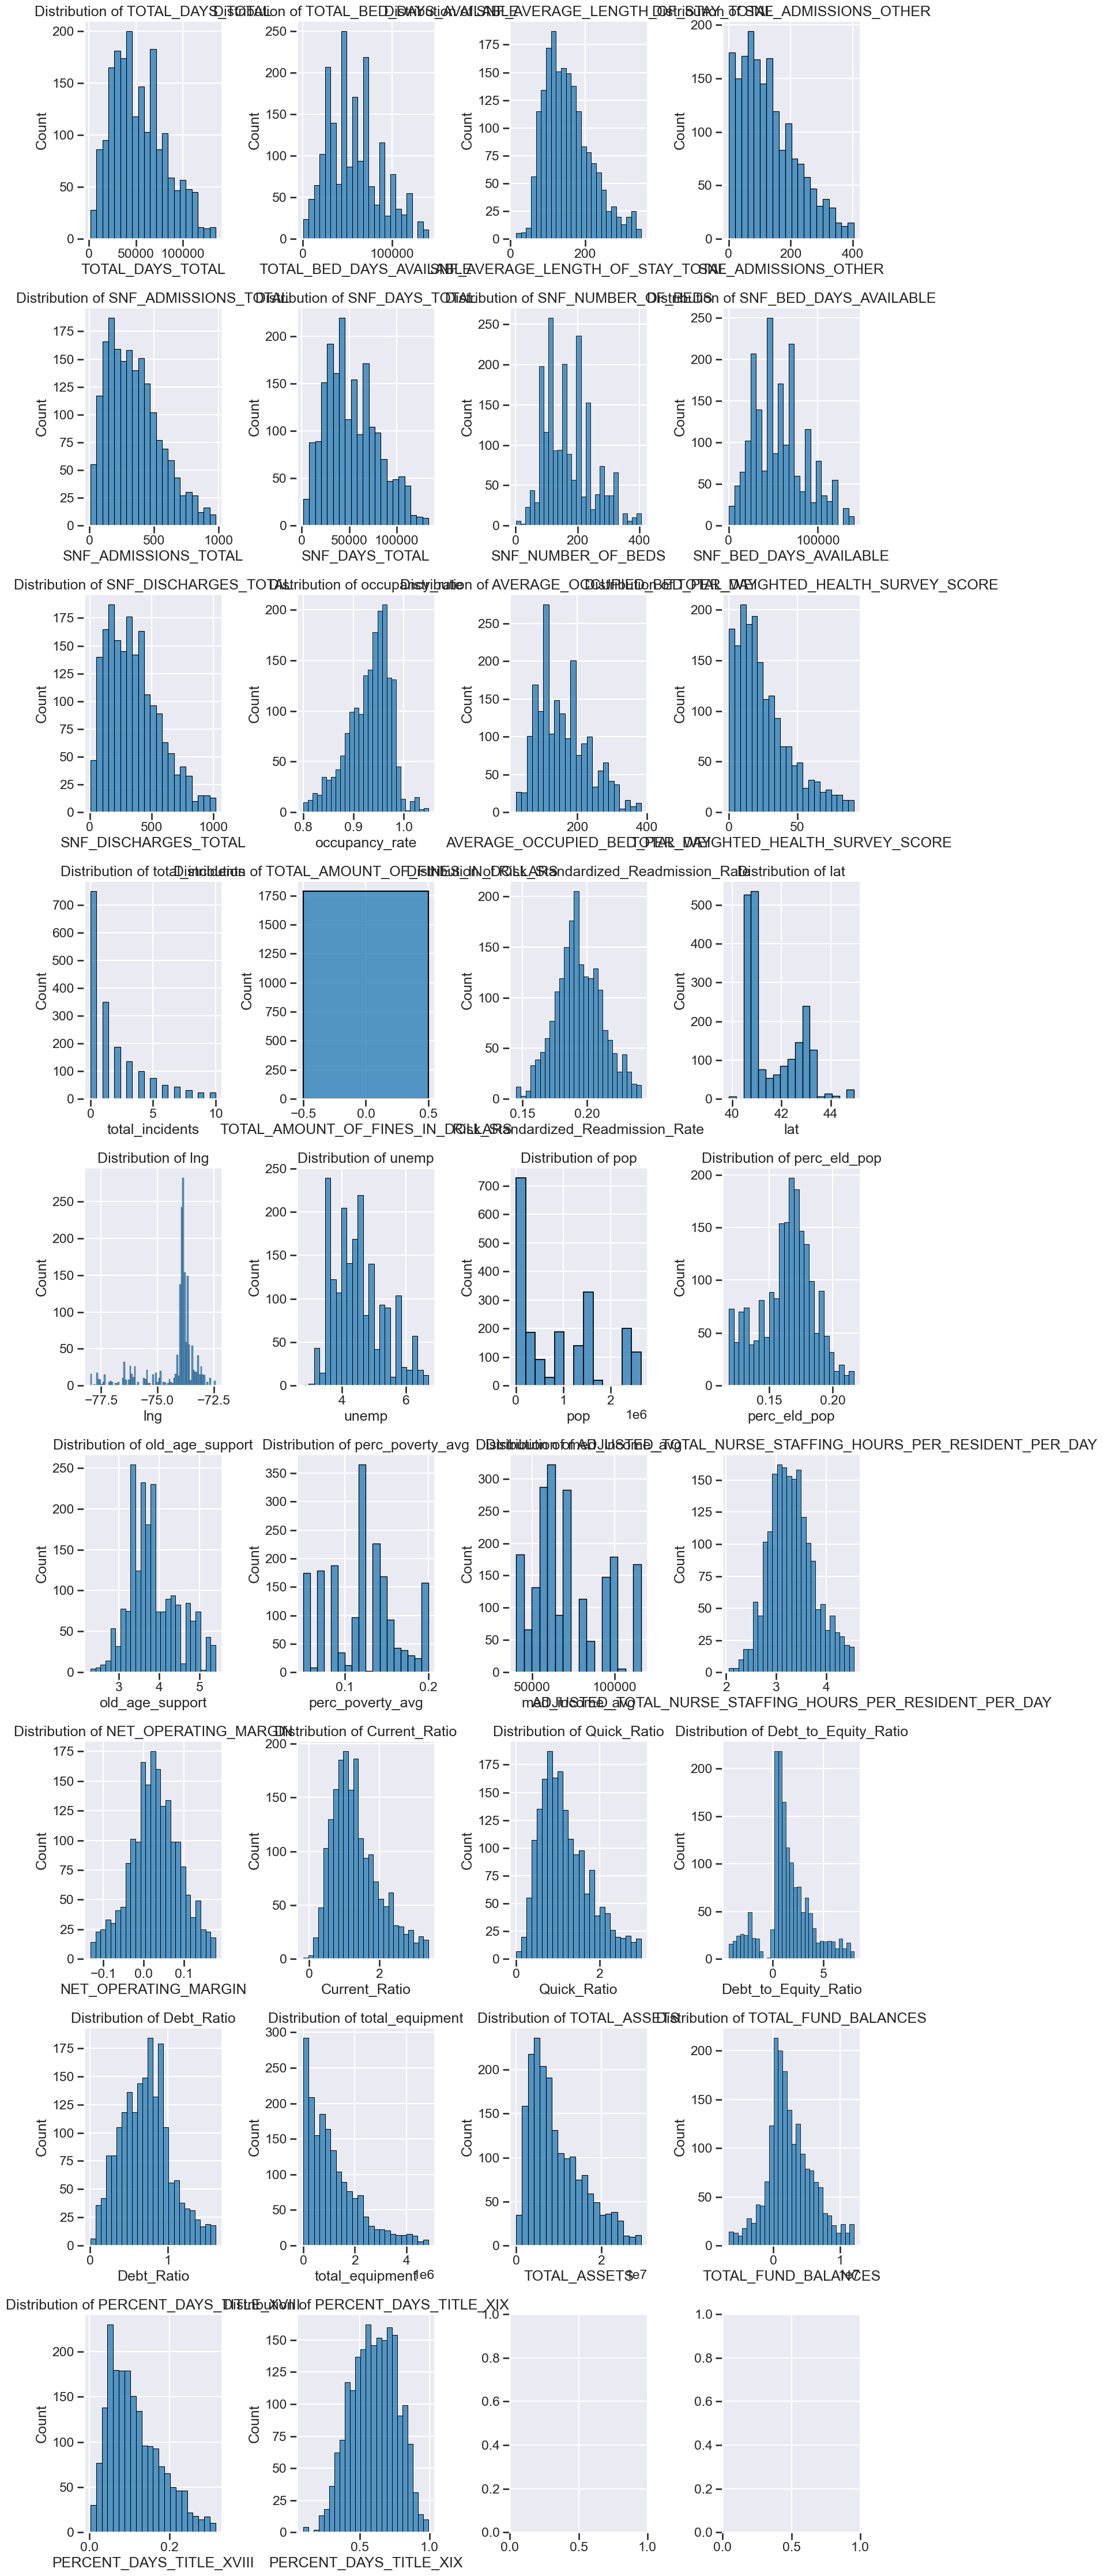

In [22]:
num_cols = len(pre_covid[continuous_cols].columns)
num_rows = (num_cols + 3) // 4  # Adjusting number of rows dynamically

fig, axes = plt.subplots(nrows=num_rows,
                         ncols=4, figsize=(15, num_rows*5))

axes = axes.flatten()

for i,col in enumerate(pre_covid[continuous_cols]): 
    
    sns.histplot(data=pre_covid, x=col,ax=axes[i])
    
    axes[i].set_title(f'Distribution of {col}')
    
    
plt.tight_layout()
    
plt.show()

Pasting list but dropping target to feed to pipeline 

In [23]:
#create last set of dummies needed before impute 
pre_covid = pd.get_dummies(pre_covid,
               columns = ['OWNERSHIP_TYPE_DETAIL',
                          'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS'],
               dtype=int,
               drop_first=True)

df = pre_covid #assign precovid data with imputed outliers and dummy cols to df to train and fit model

lets onehot encode nursing homes that exceeded max occupancy

* We see this is prevalent that some homes go over occupancy by up to 20%

* this could repeat in the future, lets see how it impacts model performance

In [24]:
#create "overflow" feature

df = df.assign(over_capacity = np.where(df['occupancy_rate'] > 1, df['occupancy_rate'] - 1, 0))

#replace total equipment less than 0 with 0 
df.loc[df['total_equipment'] < 0, 'total_equipment'] = 0

In [25]:
#all continuous column in dataset
continuous_cols = [
 'FISCAL_YEAR_DAYS',
 'FACIL_AGE',
 #'TYPE_OF_CONTROL', # this is categorical/nominal
       #'TOTAL_DAYS_TITLE_XVIII', 
       #'TOTAL_DAYS_TITLE_XIX', 
       #'TOTAL_DAYS_OTHER',
       'TOTAL_DAYS_TOTAL', 
       'TOTAL_BED_DAYS_AVAILABLE',
       'SNF_NUMBER_OF_BEDS', # this should indicate facility size to the model 
      # 'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XVIII',
     #  'SNF_AVERAGE_LENGTH_OF_STAY_TITLE_XIX',
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL', 
      # 'SNF_ADMISSIONS_TITLE_XVIII', 
       #'SNF_ADMISSIONS_OTHER',
       'SNF_ADMISSIONS_TOTAL',  
       #'SNF_DISCHARGES_TITLE_XVIII',
       #'SNF_DISCHARGES_TITLE_XIX', 
      # 'SNF_DISCHARGES_TITLE_OTHER',
       'SNF_DISCHARGES_TOTAL', 
       #occupancy 
       'OCCUPANCY_RATE', #relative occupancy for facilities to judge capacity 
       'AVERAGE_OCCUPIED_BED_PER_DAY', #magnitude of occupancy, another indicator of facility size
        'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
        #penalties and fines 
       'total_incidents',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS', 
       'Risk_Standardized_Readmission_Rate',
       #economic/location
       'LAT', 'LNG', 
       'UNEMP',
       'POP',
       #staffing 
       #'ADJUSTED_NURSE_AIDE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #'ADJUSTED_LPN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       #'ADJUSTED_RN_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
       'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY',
          'Current_Ratio',
       'Quick_Ratio', 
       'Debt_to_Equity_Ratio', 
       'Debt_Ratio',
        'perc_eld_pop', 
      'old_age_support', 
      'perc_poverty_avg', 
      'med_income_avg',
      'total_equipment', # ppe feature
      'TOTAL_ASSETS',
      #'TOTAL_LIABILITIES',
      'TOTAL_FUND_BALANCES',
      'PERCENT_DAYS_TITLE_XVIII', 
       'PERCENT_DAYS_TITLE_XIX',
       'NET_OPERATING_MARGIN'# this is the target 
       ]


categoricals = [
 'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_FAMILY',
 'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT', # deemed unimportant by xgboost model 
 'RURAL_VERSUS_URBAN_U', # deemed unimportant by xgboost model 
 #ownership type 
 #'OWNERSHIP_TYPE_DETAIL_CORPORATION',
       'OWNERSHIP_TYPE_DETAIL_INDIVIDUAL',
       'OWNERSHIP_TYPE_DETAIL_LIMITED LIABILITY COMPANY',
       'OWNERSHIP_TYPE_DETAIL_PARTNERSHIP',
       'OVER_CAPACITY']


#convert cols in list and dataframe to upper (this is sloppy)

df.columns = df.columns.str.upper()

continuous_cols = [x.upper() for x in continuous_cols]


df = df[categoricals + continuous_cols]

# Construct pipeline 

Redefine continous cols as to keep it only with X array

In [26]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,FunctionTransformer,RobustScaler,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.pipeline import Pipeline
from feature_engine.transformation import LogCpTransformer

In [27]:

#categorical pipeline 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('VarianceThreshold',VarianceThreshold(threshold=.01))])


#specify columns to log transform here 

log_cols = ['POP',
            'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE',
            #snf columns 
       'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL',
       'SNF_ADMISSIONS_TOTAL',
       
       #discharges
       'SNF_DISCHARGES_TOTAL',
       #ppe
       #'TOTAL_EQUIPMENT',
       'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS'
     ]

#log transformation 

log_transformer = LogCpTransformer(variables = log_cols)

#continuous column pipeline
numerical_transformer = Pipeline(steps=[('log_transformer',log_transformer), # log transform 
                                        ('scaler',StandardScaler())]) # scale data 

#build preprocessor to handle numericals by scaling and transforming, then impute all in pipeline
preprocessor = ColumnTransformer(transformers = [('num_transform',numerical_transformer,continuous_cols[:-1]),
                                                 ('cat_transformer',categorical_transformer,categoricals)],
                                 remainder='drop')

#preprocessing pipeline selecting variance threshold,
# impute missing values and outliers, plus scaling.
pipe = Pipeline(steps = [('preprocessor',preprocessor)])

we've observed that these "title" columns dont add nearly anything to the predictive accuracy, we dump them in turn for their "Total" counterparts.

In [28]:
from sklearn.model_selection import train_test_split

#create X and Y and split 

X = df.drop(['NET_OPERATING_MARGIN'],axis=1)

y = df[['NET_OPERATING_MARGIN']]

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,shuffle=True)

#perform imputation ahead of pipeline due to including log transformer

knn = KNNImputer(n_neighbors=20) #choose a higher number of neighbors than default to avoid noisy imputation

X_train = pd.DataFrame(knn.fit_transform(X_train),columns=X_train.columns)

X_test = pd.DataFrame(knn.transform(X_test),columns=X_test.columns)

#transform X 

X_train = pd.DataFrame(pipe.fit_transform(X_train))

#notice we only call transform here, we do not fit the pipeline to the test set 
X_test = pd.DataFrame(pipe.transform(X_test))

In [29]:
#get feature names from preprocessor 
feature_to_keep_list = preprocessor.get_feature_names_out().tolist()
#split on double underscore 
features_to_keep = [x.split('__')[1]  for x in feature_to_keep_list]

rename fields for interpretability 

In [30]:
X_train.columns = features_to_keep

X_test.columns = features_to_keep

# impute target and examine distribution 

In [31]:
imp = KNNImputer() 

y_train = imp.fit_transform(y_train)

y_test = imp.transform(y_test)

# visualize distribution and .describe() 

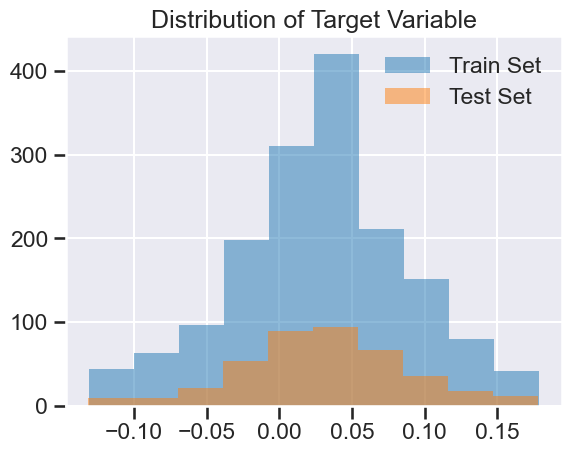

-0.131251674 0.178777294
-0.131550375 0.178109386


In [32]:

plt.hist(y_train,label='Train Set',alpha=.5)

plt.hist(y_test,label='Test Set',alpha=.5)

plt.title('Distribution of Target Variable')

plt.legend()

plt.show()

print(y_train.min(),y_train.max()) 

print(y_test.min(),y_test.max())

In [34]:
#lets run RFE to find the optimal features for our dataset. 

from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

rfecv = RFECV(estimator=Ridge(),
              step=1,
              cv=10)

rfecv.fit(X_train,y_train)

RFECV(cv=10, estimator=Ridge())

In [35]:
# Print the ranking of each feature (1 indicates selected, 0 indicates not selected)
print("Feature ranking:", rfecv.ranking_)

# Print the selected features
selected_features = [i for i, rank in enumerate(rfecv.ranking_) if rank == 1]
print("Selected features:", selected_features)

Feature ranking: [1 5 1 1 1 1 1 1 1 1 1 1 8 2 1 7 1 1 1 3 1 1 1 1 4 1 1 1 1 1 1 6 1 1 1 1 1
 1]
Selected features: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37]


In [36]:
X_train = X_train.iloc[:,selected_features]
X_test = X_test.iloc[:,selected_features]

In [37]:
# Quickly test lots of models 

def train_models(X_train, X_test,y_train,y_test, model_dict):

    from sklearn.linear_model import Ridge,ElasticNet,Lasso
    from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,HistGradientBoostingRegressor
    from xgboost import XGBRegressor
    from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,mean_squared_log_error
    from sklearn.model_selection import train_test_split

    models = model_dict

    for model_name, model in models.items():
        
        model.fit(X_train, y_train)  # train models
        
        # Make Predictions
        y_train_preds = model.predict(X_train)
        y_test_preds = model.predict(X_test)
        
        # Training Set Performance
        model_r2_train = r2_score(y_train, y_train_preds)
        model_r2_test = r2_score(y_test, y_test_preds)
        
        model_rmse_train = np.sqrt(mean_squared_error(y_train, y_train_preds))
        model_rmse_test = np.sqrt(mean_squared_error(y_test, y_test_preds))
        
        
        model_mae_train = mean_absolute_error(y_train, y_train_preds)
        model_mae_test = mean_absolute_error(y_test, y_test_preds)
        
        # Print results with model name
        print(f"\nPerformance for {model_name} Model:")
        print("Training Set Performance:")
        print(f"  R^2 Score (Training): {model_r2_train:.4f}")
        print(f"  Root Mean Squared Error (Training): {model_rmse_train:.4f}")
        print(f"  Mean Absolute Error (Training): {model_mae_train:.4f}")

        print("\nTesting Set Performance:")
        print(f"   R^2 Score (Testing): {model_r2_test:.4f}")
        print(f"   Root Mean Squared Error (Testing): {model_rmse_test:.4f}")
        print(f"   Mean Absolute Error (Testing): {model_mae_test:.4f}")

Engineer Regional Cluster on longitude and latitude

from sklearn.cluster import KMeans 

#score clusters 

from sklearn.metrics import silhouette_score

# Specifying the range of clusters to test
max_clusters = 6
silhouette_scores = []

for n_clusters in range(2, max_clusters + 1):
    # Creating KMeans instance
    kmeans = KMeans(n_clusters=n_clusters)
    # Fitting the model
    vars_to_cluster = ['LAT','LNG','SNF_ADMISSIONS_TOTAL','SNF_DISCHARGES_TOTAL']
    kmeans.fit(X_train[vars_to_cluster])
    # Appending the sum of squared distances to list
    silhouette_scores.append(silhouette_score(X_train[vars_to_cluster],
                                              kmeans.labels_))

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Elbow Plot')
plt.xlabel('N Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

Score features using f-regression to look at potential clustering opportunities

In [38]:
from sklearn.feature_selection import SelectKBest,f_regression, mutual_info_regression
#kbest (F Regression Scores)
kbest = SelectKBest(score_func=f_regression,k=len(X_train.columns))

bestk_feats = kbest.fit_transform(X_train,y_train)

selected = kbest.get_support(indices=True) 

kseries = pd.Series(kbest.scores_,index = X_train.loc[selected].columns)

kseries.sort_values(ascending=False)


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



TOTAL_FUND_BALANCES                                         307.272479
DEBT_RATIO                                                  232.007793
QUICK_RATIO                                                  72.813610
LAT                                                          63.778017
OCCUPANCY_RATE                                               55.823317
ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY     50.515591
TOTAL_ASSETS                                                 48.331142
PERC_ELD_POP                                                 39.594547
PERCENT_DAYS_TITLE_XVIII                                     38.777106
AVERAGE_OCCUPIED_BED_PER_DAY                                 38.674009
TOTAL_DAYS_TOTAL                                             37.817251
SNF_NUMBER_OF_BEDS                                           35.595745
TOTAL_BED_DAYS_AVAILABLE                                     34.152842
TOTAL_INCIDENTS                                              33.201509
TOTAL_

In [39]:

#define models to test 

from sklearn.linear_model import Lasso, Ridge,LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor

model_dict = {'Lasso':Lasso(),
              'Ridge':Ridge(),
              'KNN':KNeighborsRegressor(n_neighbors=10),
              'Random Forest':RandomForestRegressor(max_depth=4),
              'Gradient Boosted Regressor':GradientBoostingRegressor(max_depth=3),
              'XGBOOST':XGBRegressor(max_depth=3),
              'Linear':LinearRegression(),
              'DecisionTreeRegressor':DecisionTreeRegressor(max_depth=8)}

train_models(X_train,X_test,y_train,y_test,model_dict=model_dict)


Performance for Lasso Model:
Training Set Performance:
  R^2 Score (Training): 0.0000
  Root Mean Squared Error (Training): 0.0600
  Mean Absolute Error (Training): 0.0457

Testing Set Performance:
   R^2 Score (Testing): -0.0011
   Root Mean Squared Error (Testing): 0.0567
   Mean Absolute Error (Testing): 0.0434

Performance for Ridge Model:
Training Set Performance:
  R^2 Score (Training): 0.2692
  Root Mean Squared Error (Training): 0.0513
  Mean Absolute Error (Training): 0.0402

Testing Set Performance:
   R^2 Score (Testing): 0.1962
   Root Mean Squared Error (Testing): 0.0508
   Mean Absolute Error (Testing): 0.0403

Performance for KNN Model:
Training Set Performance:
  R^2 Score (Training): 0.4079
  Root Mean Squared Error (Training): 0.0462
  Mean Absolute Error (Training): 0.0363

Testing Set Performance:
   R^2 Score (Testing): 0.2482
   Root Mean Squared Error (Testing): 0.0491
   Mean Absolute Error (Testing): 0.0384


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Performance for Random Forest Model:
Training Set Performance:
  R^2 Score (Training): 0.3706
  Root Mean Squared Error (Training): 0.0476
  Mean Absolute Error (Training): 0.0374

Testing Set Performance:
   R^2 Score (Testing): 0.2518
   Root Mean Squared Error (Testing): 0.0490
   Mean Absolute Error (Testing): 0.0393


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:424: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().




Performance for Gradient Boosted Regressor Model:
Training Set Performance:
  R^2 Score (Training): 0.6015
  Root Mean Squared Error (Training): 0.0379
  Mean Absolute Error (Training): 0.0296

Testing Set Performance:
   R^2 Score (Testing): 0.3588
   Root Mean Squared Error (Testing): 0.0454
   Mean Absolute Error (Testing): 0.0360

Performance for XGBOOST Model:
Training Set Performance:
  R^2 Score (Training): 0.7975
  Root Mean Squared Error (Training): 0.0270
  Mean Absolute Error (Training): 0.0201

Testing Set Performance:
   R^2 Score (Testing): 0.4069
   Root Mean Squared Error (Testing): 0.0437
   Mean Absolute Error (Testing): 0.0336

Performance for Linear Model:
Training Set Performance:
  R^2 Score (Training): 0.2693
  Root Mean Squared Error (Training): 0.0513
  Mean Absolute Error (Training): 0.0402

Testing Set Performance:
   R^2 Score (Testing): 0.1954
   Root Mean Squared Error (Testing): 0.0508
   Mean Absolute Error (Testing): 0.0404

Performance for DecisionTre

# Lets fit a linear model with our new features

In [40]:
#kbest (F Regression Scores)
kbest = SelectKBest(score_func=f_regression,k=18)

bestk_feats = kbest.fit_transform(X_train,y_train)

selected = kbest.get_support(indices=True) 

kseries = pd.Series(kbest.scores_,index = X_train.loc[selected].columns)

print('Top 20 Features')

k_25 = kseries.sort_values(ascending=False)[:25]

Top 20 Features


/Users/jack/tensorflow-test/env/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [41]:
linear_model = Ridge()

linear_model.fit(X_train,y_train)

Ridge()

In [42]:
coefs = pd.Series(linear_model.coef_.flatten(),index=X_train.columns)

coefs = coefs.sort_values(ascending=False,key=lambda x: abs(x))

coefs

PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS               -0.040682
RURAL_VERSUS_URBAN_U                                       -0.018458
TOTAL_FUND_BALANCES                                         0.016387
TOTAL_DAYS_TOTAL                                            0.009933
DEBT_RATIO                                                 -0.009517
WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT                -0.008617
PERCENT_DAYS_TITLE_XVIII                                    0.008350
AVERAGE_OCCUPIED_BED_PER_DAY                               -0.007302
SNF_ADMISSIONS_TOTAL                                       -0.007003
FISCAL_YEAR_DAYS                                           -0.005399
OCCUPANCY_RATE                                              0.004807
ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY   -0.004703
SNF_AVERAGE_LENGTH_OF_STAY_TOTAL                            0.004226
OWNERSHIP_TYPE_DETAIL_PARTNERSHIP                           0.004146
TOTAL_INCIDENTS                   

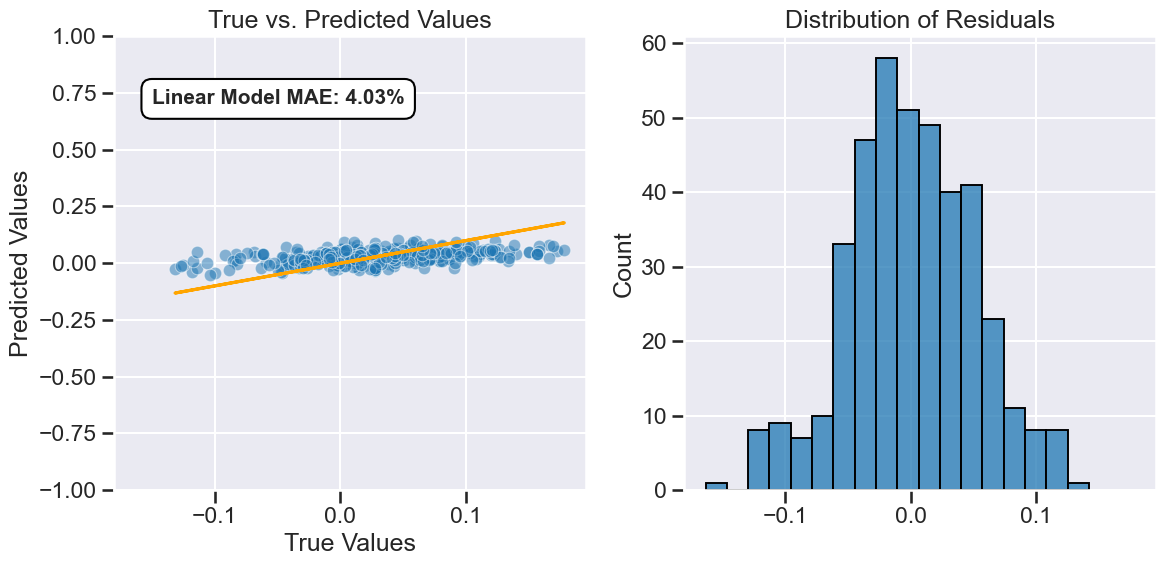

In [43]:
# import mae function 
from sklearn.metrics import mean_absolute_error 
y_true = pd.Series(y_test.flatten())

y_pred = linear_model.predict(X_test)

preds = pd.Series(y_pred.flatten())

linear_mae = mean_absolute_error(y_true,preds)
#DEFINE RESIDUALS 
resid = y_true - preds

fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,6),sharex=True)

sns.scatterplot(x=y_true, y=preds,ax=ax[0],alpha=.5)

sns.histplot(resid,ax=ax[1])

# Add a diagonal line representing perfect predictions
ax[0].plot(y_true,y_true, linestyle='-', color='orange',label='Perfect Prediction')

ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].tick_params(axis='both')
ax[0].set_title('True vs. Predicted Values')
ax[0].set_ylim([-1,1])
ax[0].text(x=-.15,y=.7,s = f'Linear Model MAE: {linear_mae * 100:.2f}%',
           fontsize=15,
           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'),
           fontweight='bold')

ax[1].set_title('Distribution of Residuals')
fig.tight_layout()


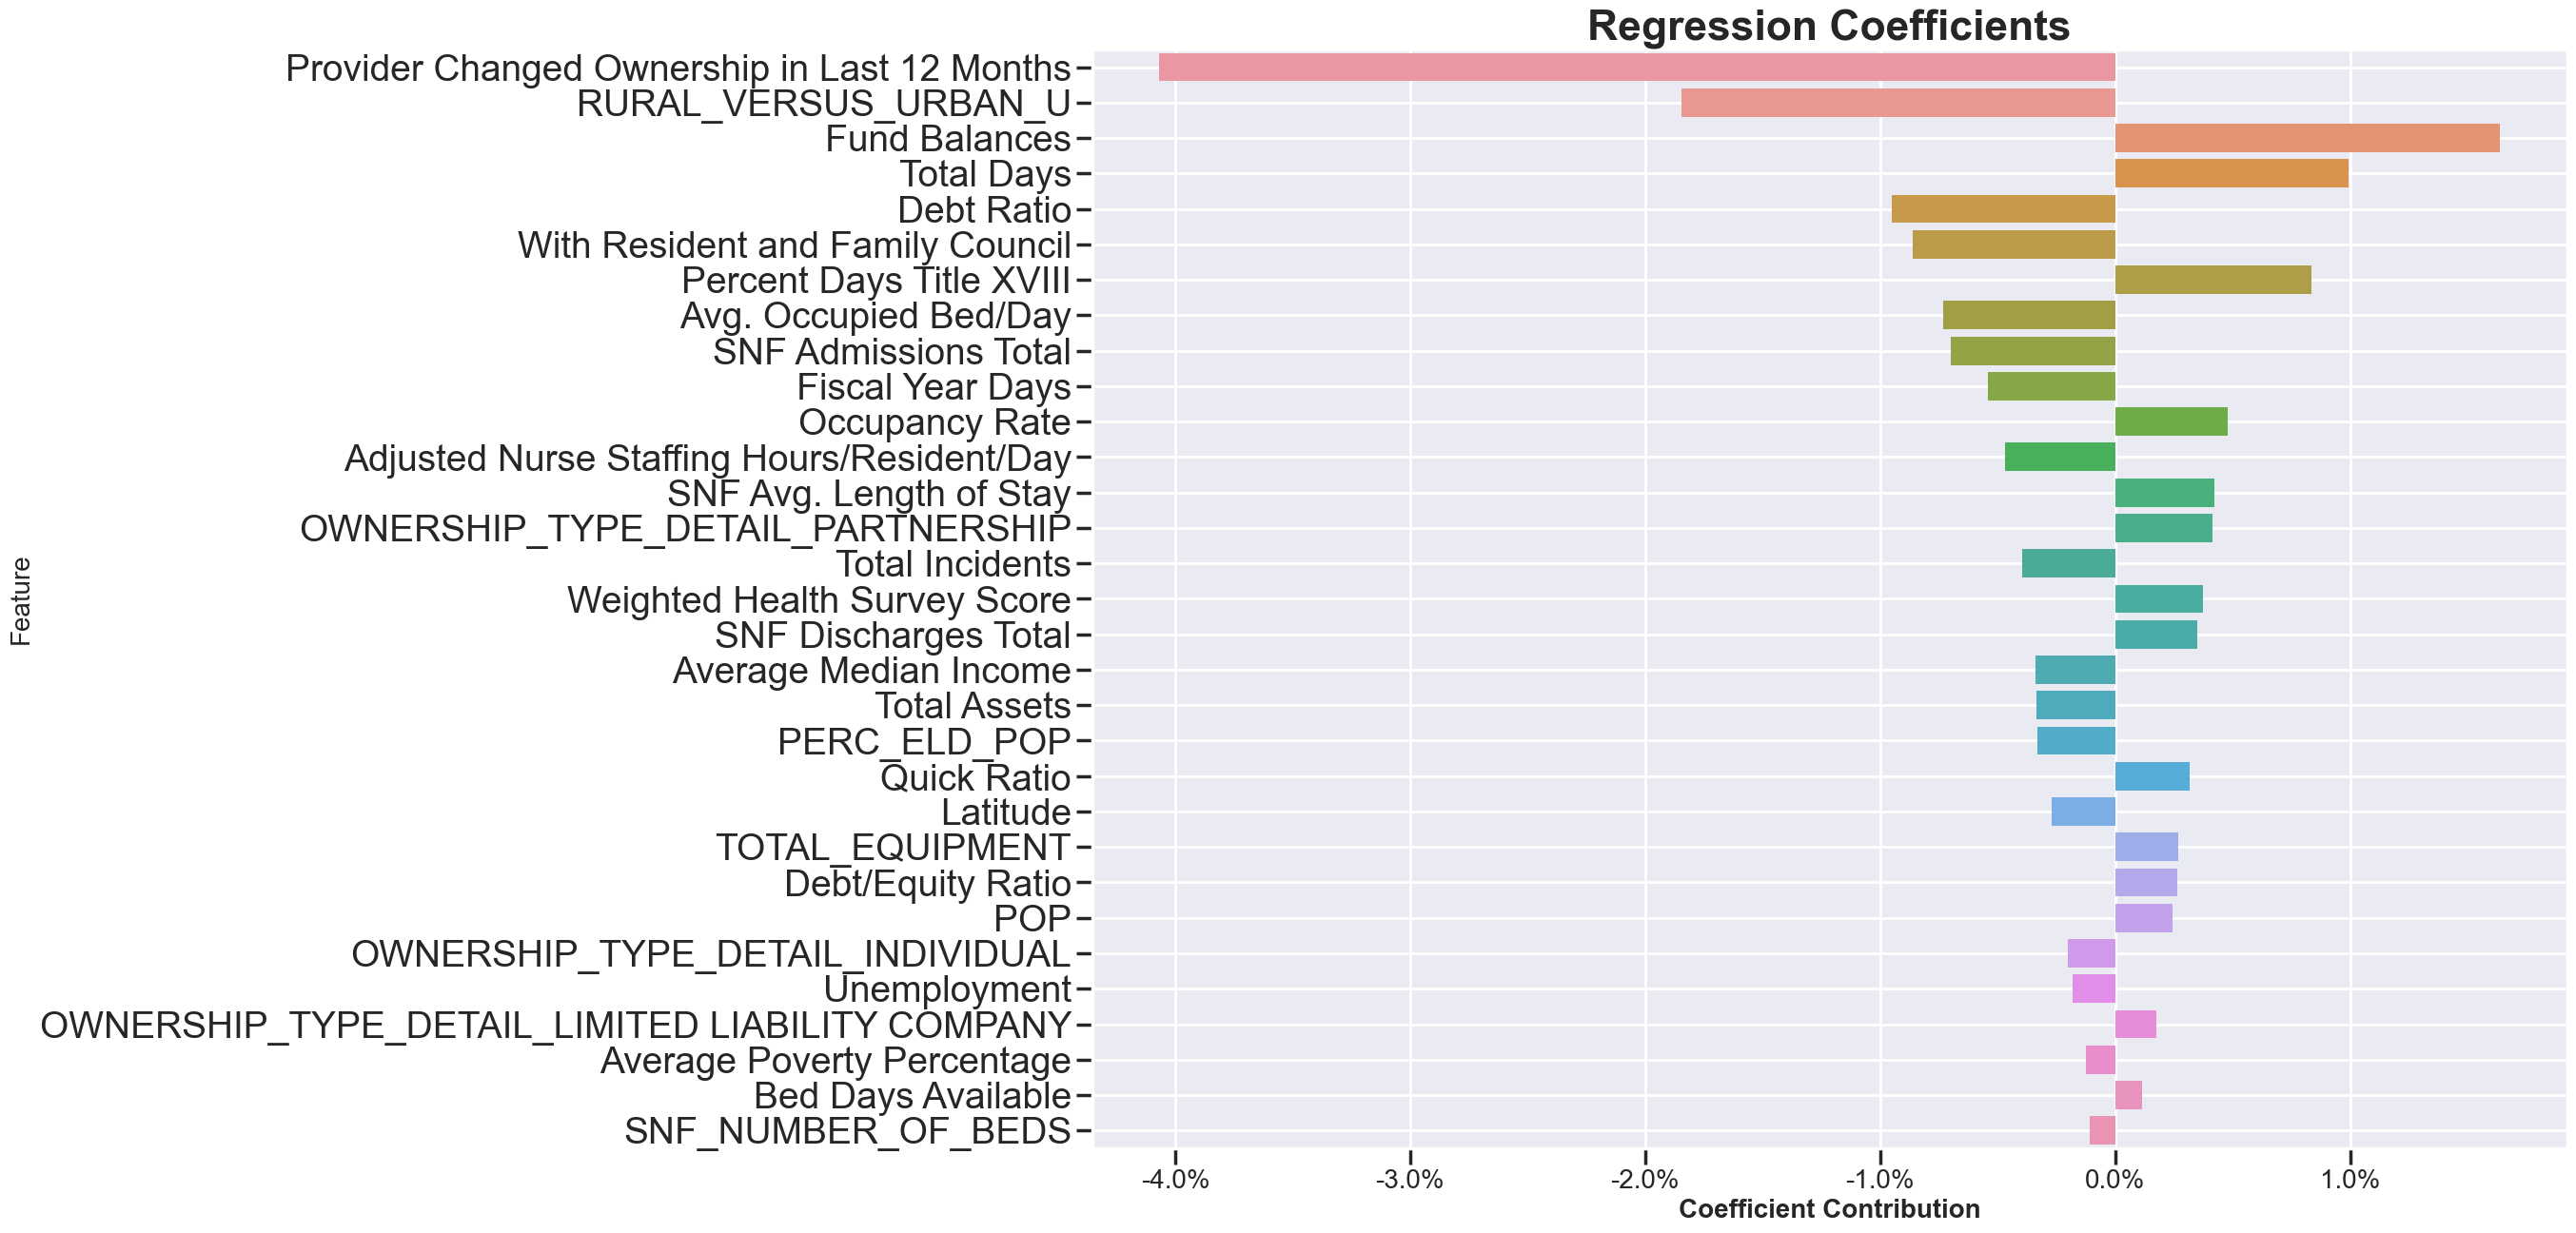

In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Your dictionary mapping feature names to shorter versions
feature_code_map = {
    'DEBT_TO_EQUITY_RATIO': 'Debt/Equity Ratio',
    'TOTAL_BED_DAYS_AVAILABLE': 'Bed Days Available',
    'TOTAL_DAYS_TOTAL': 'Total Days',
    'TOTAL_FUND_BALANCES': 'Fund Balances',
    'CURRENT_RATIO': 'Current Ratio',
    'PERCENT_DAYS_TITLE_XVIII': 'Percent Days Title XVIII',
    'OCCUPANCY_RATE': 'Occupancy Rate',
    'DEBT_RATIO': 'Debt Ratio',
    'SNF_ADMISSIONS_TOTAL': 'SNF Admissions Total',
    'FISCAL_YEAR_DAYS': 'Fiscal Year Days',
    'LAT': 'Latitude',
    'SNF_AVERAGE_LENGTH_OF_STAY_TOTAL': 'SNF Avg. Length of Stay',
    'ADJUSTED_TOTAL_NURSE_STAFFING_HOURS_PER_RESIDENT_PER_DAY': 'Adjusted Nurse Staffing Hours/Resident/Day',
    'SNF_DISCHARGES_TOTAL': 'SNF Discharges Total',
    'TOTAL_WEIGHTED_HEALTH_SURVEY_SCORE': 'Weighted Health Survey Score',
    'AVERAGE_OCCUPIED_BED_PER_DAY': 'Avg. Occupied Bed/Day',
    'WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT': 'With Resident and Family Council',
    'TOTAL_INCIDENTS': 'Total Incidents',
    'MED_INCOME_AVG': 'Average Median Income',
    'QUICK_RATIO': 'Quick Ratio',
    'TOTAL_ASSETS': 'Total Assets',
    'TOTAL_AMOUNT_OF_FINES_IN_DOLLARS': 'Total Fines',
    'PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS': 'Provider Changed Ownership in Last 12 Months',
    'UNEMP': 'Unemployment',
    'PERC_POVERTY_AVG': 'Average Poverty Percentage'
}
sns.set_context('poster')
# Assuming coef is your DataFrame containing regression coefficients
# Replace coef.index with the mapped names using feature_code_map
coef = pd.DataFrame(coefs, columns=['Regression Coefficient'])

fig, ax = plt.subplots(figsize=(20, 15))

sns.barplot(data=coef, 
            y=[feature_code_map.get(feature, feature) for feature in coef.index],
            x='Regression Coefficient', 
            orient='h', ax=ax, dodge=True)

plt.title('Regression Coefficients', fontsize=32, fontweight='bold')
plt.xlabel('Coefficient Contribution', fontsize=20, fontweight='bold')
plt.ylabel('Feature', fontsize=20)

# Format as percentage
def percent_formatter(x, pos): 
    return '{:.1%}'.format(x)

plt.xticks(fontsize=20)
plt.yticks(fontsize=28)

ax.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
plt.grid(True)

plt.show()

In [45]:
linear_coefs = pd.DataFrame((coefs * 100).round(2),columns=['Percentage Contribution'])

In [48]:
quantiles = linear_coefs.quantile([i/10 for i in range(1, 10)])

# Define style function for highlighting top 3 and bottom 3 features
def highlight_top_bottom_features(val):
    styles = [''] * len(val)  # Default style for all cells
    for col in val.index:
        q1 = quantiles.loc[0.2, col]
        q3 = quantiles.loc[0.8, col]
        if val[col] < q1:
            styles[val.index.get_loc(col)] = 'background-color: #FF9999'
        elif val[col] > q3:
            styles[val.index.get_loc(col)] = 'background-color: lightgreen'
    return styles

# Apply conditional formatting
styled_df = linear_coefs[:9].round(3).style.apply(highlight_top_bottom_features, axis=1)

styled_df


,Percentage Contribution
PROVIDER_CHANGED_OWNERSHIP_IN_LAST_12_MONTHS,-4.070000
RURAL_VERSUS_URBAN_U,-1.850000
TOTAL_FUND_BALANCES,1.640000
TOTAL_DAYS_TOTAL,0.990000
DEBT_RATIO,-0.950000
WITH_A_RESIDENT_AND_FAMILY_COUNCIL_RESIDENT,-0.860000
PERCENT_DAYS_TITLE_XVIII,0.840000
AVERAGE_OCCUPIED_BED_PER_DAY,-0.730000
SNF_ADMISSIONS_TOTAL,-0.700000
